In [1]:
from numpy import *
# from matplotlib.pyplot import *
# import os
# ion()

# find hinges
def splitHinge(vals, sites, block):
    # split hinges
    currBlock = 1
    index = 0
    isStart = False
    newSites = []
    newVals = []

    for val in vals:
        if block[index] == currBlock and not isStart:
            isStart = True
            currSites = [sites[index]]
            currValLists = [vals[index]]
        elif block[index] == currBlock and isStart:
            currSites.append(sites[index])
            currValLists.append(vals[index])
        else:
            currBlock += 1
            isStart = True
            newSites.append(currSites)
            newVals.append(currValLists)
            currSites = [sites[index]]
            currValLists = [vals[index]]
        if currBlock == block[-1] and index == len(vals) - 1:
            newSites.append(currSites)
            newVals.append(currValLists)
        index += 1
    # print newSites, newVals
    return newSites, newVals


def mini(a, b):
    if a > b:
        return a
    else:
        return b


def checkIfCrossBase(currVal, currSite, currEigenVec):
    identify = sort(currVal)
    ifRemain = True
    if identify[0] < 0 and identify[-1] > 0:
        ifRemain = True
    else:
        maxSite = max(currSite)
        minSite = min(currSite)
        # print (identify)
        if identify[0] >= 0 and identify[-1] >= 0:
            if currEigenVec[max(0, minSite - 1)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 1)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 2)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 3)] < 0:
                ifRemain = True
            else:
                ifRemain = False
        elif identify[0] <= 0 and identify[-1] <= 0:
            # print (len(currEigenVec))
            # print (currEigenVec[239])

            if currEigenVec[max(0, minSite - 1)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 1))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 2))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 3))] > 0:
                ifRemain = True
            else:
                ifRemain = False

        else:
            print(identify[0], identify[-1])
            print("Check!")
    return ifRemain


def oneModeHinge(currEigenVec, thereshold=20):
    range = ((1 / float(len(currEigenVec))) ** 0.5) / thereshold
    # print (range)
    # print range
    sites = []
    vals = []
    block = []

    index = 0
    blockID = 1
    for item in currEigenVec:
        if item <= range and item >= -range:
            vals.append(item)
            if len(sites) >= 1 and abs(sites[-1] - index) > 1:
                blockID += 1
            sites.append(index)
            block.append(blockID)
        index += 1

    newSites, newVals = splitHinge(vals, sites, block)

    filtSites = []
    filtVals = []

    index = 0
    for item in newSites:
        currSite = newSites[index]
        currVal = newVals[index]
        if checkIfCrossBase(currVal, currSite, currEigenVec):
            filtSites.append(currSite)
            filtVals.append(currVal)
        index += 1

    return filtSites, filtVals


def getValue(currList):
    newList = []
    for item in currList:
        newList.append(float(item))
    return newList


def readModes(fileName):
    allModes = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.strip()
            line = line.split('\t')
            currMode = line[0]
            currVal = line[1:]
            allModes[currMode] = getValue(currVal)
    return allModes


def flattenData(arrayTwoD):
    flat = []
    for item in arrayTwoD:
        for each in item:
            flat.append(each)
    return flat

def cleanStr(currStr):
    return currStr.strip('\'')

def readFile(fileName):
    data = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.replace('\n', '')
            line = line.strip()
            line = line.split('\t')
            currPDB = line[0]
            currDrug = line[1]
            currChain = line[2:]
            if currPDB not in data.keys():
                data[currPDB] = {}
            if currDrug not in data[currPDB].keys():
                data[currPDB][currDrug] = []
            for each in currChain:
                data[currPDB][currDrug].append(cleanStr(each))
    return data

# contribution of mode of motions
def getContribution(eigenVals, mode):
    allContribution = sqrt(sum(1 / eigenVals))
    currModeContribution = eigenVals[:mode]
    currContribution = sqrt(sum(1 / currModeContribution))
    return currContribution / allContribution

def getModesGivenThreshold(eigenVals, thereshold):
    contribution = 0
    mode = 0
    while contribution <= thereshold:
        mode += 1
        contribution = getContribution(eigenVals, mode)
    return mode

def writeBinding(fileName, pdb_ids):
    with open(fileName, 'w') as wf:
        for item in pdb_ids:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')


from prody import *
def getModes(currPDB, eachChain, length = 0.7, rmsd = 1.0, Z = 10):    
    # if not os.path.exists('./Results/' + currPath):
    #     os.mkdir('./Results/' + currPath)
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len = length, cutoff_rmsd = rmsd, cutoff_Z = Z)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    
    ags = parsePDB(pdb_ids, subset='ca')
    dali_ens = buildPDBEnsemble(ags, mapping=mappings, seqid=20)
    gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
    eigVals = gnms.getEigvals()
    averageEigVals = mean(eigVals, axis=0)

    eigVects = gnms.getEigvecs()
    averageEigVects = mean(eigVects, axis=0)
    return averageEigVals, averageEigVects, pdb_ids, gnms, averageEigVects

            
def getDali_info(currPDB, eachChain, rmsd = 2.5, length = 0.9):
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len=length, cutoff_rmsd=rmsd)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of diverse structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    return pdb_ids, mappings

def getHinges(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge


def getHinges_modes(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def get3Hinges_bandwidth(averageEigVects, bandWidths = [15, 16, 17]):
    currHinge = []
    for i in range(3):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidths[i])
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [2]:
def oneModeHinge_update(values, thereshold=20):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    # print (regions)
    
    FinalRegions = []
    for region in regions:
        # print ('before filtering', region)
        if len(region) >= 4:
            # print ('previous region', region)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            n = int(len(region) / 4) + 1
            region = pos[:n] + neg[:n]
            # print (region, neg, pos)
        elif len(region) == 3:  
            region = find_cross_points(region, crossovers, values)
            # if values[region[0]-1] * values[region[-1]+1] > 0:
            #     continue  # Skip this region if adjacent values outside the band have the same sign

        # print ('after filtering',region)      
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    # print ('Final regions', FinalRegions)
    # remove frist and last several residues as hinges
    updateRegions = []
    for currReg in FinalRegions:
        if trimEnds(values, currReg, 15):
            updateRegions.append(currReg)
    
    flat = flattenData(updateRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return updateRegions, final_values

def getHinges2(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

def getHinges_modes2(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge



In [4]:
# Experiment to evaluate performance of hypergeometric p values
from scipy.stats import hypergeom
def ORA(M, N, n, k):
    total = 0
    totalLength = N
    binding = M
    hinge = n
    overlap = k
    
    for i in range(overlap):
        total += hypergeom.pmf(i, totalLength, binding, hinge)
    return 1 - total


import os
def writeIDs(path, idList):
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:

       # Create a new directory because it does not exist
       os.makedirs(path)
       print("The new directory is created!")
    
    with open(path + '/ids_diverse.txt', 'w') as wf:
        for item in idList:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')

In [5]:
def writeNumbers(path, numbers):
    with open(path, 'w') as wf:
        for item in numbers:
            wf.write(str(item) + '\n')

def merge_overlapping_lists(lists):
    sorted_lists = sorted(lists, key=lambda x: x[0])  # Sort lists based on the first element
    merged_lists = [sorted_lists[0]]
    
    for current in sorted_lists[1:]:
        previous = merged_lists[-1]
        # Check if the current list overlaps with the previous one
        if current[0] <= previous[-1]:
            # Merge overlapping lists by updating the last list in merged_lists
            merged_lists[-1] = list(range(min(previous[0], current[0]), max(previous[-1], current[-1])+1))
        else:
            merged_lists.append(current)
    return merged_lists

# Method 3

In [6]:
def trimEnds(values, lists, Number):
    begining = Number
    ends = len(values) - Number
    isInclude = True
    for item in lists:
        if item < begining or item > ends:
            isInclude = False
    return isInclude

def splitRegions(currlist):
    sortList = sort(currlist)
    
    region_list = []
    currRegion = []
    previous = -1
    for item in sortList:
        if item - previous == 1:
            currRegion.append(item)
            previous = item
        else:
            if currRegion != []:
                region_list.append(currRegion)
            currRegion = [item]
            previous = item
    
    if currRegion not in region_list:
        region_list.append(currRegion)
    return region_list
        
def extendRegions(crossovers, values, thereshold):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    return regions


In [7]:
def mergeRegions(lists, max_gap=2, min_length=5):
    merged = [lists[0]]  # Start with the first list

    for next_list in lists[1:]:
        # Check if the next list starts within max_gap+1 of the last element of the current last list in 'merged'
        if next_list[0] - merged[-1][-1] <= max_gap + 1:
            # Merge the lists by extending the last list in 'merged' with the elements of 'next_list'
            merged[-1].extend(next_list)
        else:
            # If it doesn't meet the merge criteria, just append the list as a new one
            merged.append(next_list)

    # Filter merged lists to ensure they meet the min_length requirement after removing duplicates and sort them
    # Keep unmerged lists as they are
    final_list = []
    for sublist in merged:
        unique_sublist = sorted(set(sublist))  # Remove duplicates and sort
        if len(unique_sublist) >= min_length or unique_sublist == sublist:  # Check length or unchanged list
            final_list.append(unique_sublist)
        else:
            # For lists that were attempted to merge but didn't meet the length requirement,
            # revert to individual elements as separate lists
            final_list.extend([[item] for item in unique_sublist])

    # print (final_list)
    finals = []
    for item in final_list:
        if len(item) < min_length:
            finals += splitRegions(item)
        else:
            finals.append(item)
    
    return finals

In [8]:
# Function to trim similar sign values from start
def trim_start(lst, index):
    if len(lst) == 1:
        return lst, index
    if not lst:
        return [], []
    start_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != start_sign:
            return lst[i-1:], index[i-1:]
    return [], []

# Function to trim similar sign values from end
def trim_end(lst, index):
    if len(lst) == 1:
        return lst, index
    
    if not lst:
        return [], []
    lst = lst[::-1]  # Reverse the list for ease of use
    index = index[::-1]
    end_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != end_sign:
            return lst[i-1:][::-1], index[i-1:][::-1]  # Reverse the list again to restore original order
    return [], []

def trimRegions(region, values):
    newRegion = []
    for eachIndex in region:
        currValues = [values[x] for x in eachIndex]
        # print (eachIndex, currValues)
        # Apply the trimming functions
        trimmed_start, trimmed_index = trim_start(currValues, eachIndex)
        # print (trimmed_index)
        trimmed_end, trimmed_index = trim_end(trimmed_start, trimmed_index)
        newRegion.append(trimmed_index)
    return newRegion

In [9]:
def findSmallestPairs(index_list, value_list):
    # Initialize variables to store the smallest sum and corresponding indices
    smallest_sum = float('inf')  # Set it to infinity initially
    smallest_pair = None

    # Iterate through the value list to find adjacent index pairs with the smallest sum of absolute values
    for i in range(len(value_list) - 1):  # -1 because we are looking at pairs
        current_sum = abs(value_list[i]) + abs(value_list[i + 1])
        if current_sum < smallest_sum:
            smallest_sum = current_sum
            smallest_pair = [index_list[i], index_list[i + 1]]
    return smallest_pair

def find_cross_points(Final_test, crossovers, values):
    crossoverPoints_pairs = []
    for item in Final_test:
        if item in crossovers and item - 1 in Final_test:
            crossoverPoints_pairs.append([item - 1, item])
    
    # print ('cross_pairs', crossoverPoints_pairs)
    # filtering_pairs = mergeRegions(crossoverPoints_pairs, max_gap=0, min_length=3)
    # currNumber = len(filtering_pairs) * 2
    if crossoverPoints_pairs == []:
        return []
    
    bestPairs = crossoverPoints_pairs[0]
    bestScore = abs(values[bestPairs[0]]) + abs(values[bestPairs[1]])
    if len(crossoverPoints_pairs) <= 1:
        return bestPairs
    else:
        for item in crossoverPoints_pairs[1:]:
            currScore = abs(values[item[0]]) + abs(values[item[1]])
            # print ('item, score', item, currScore)
            if currScore <= bestScore:
                bestPairs = item
                bestScore = currScore
    
    # print ('filtered', bestPairs)
    return bestPairs


In [10]:
def filteringCriteria(Final, values, crossovers):
    FinalRegions = []
    for region in Final:
        # print ('before filtering', region)
        if len(region) >= 4:
            # print ('region, crossovers, values', region, crossovers)
            allPairs = find_cross_points(region, crossovers, values)
            currRegion = allPairs
            
            # print ('allPairs', allPairs)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            extra = round((len(region) - len(currRegion)) / 4 + 0.00001)
            
            # rest = pos[1:] + neg[1:]
            # restValues = [values[res] for res in rest]
            # combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            rest = []
            for item in region:
                if item not in currRegion:
                    rest.append(item)
            restValues = [values[res] for res in rest]   
            combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            
            # Extract the sorted indexes from the combined list
            sorted_indexes = [index for index, value in combined_list]
            
            region = currRegion + sorted_indexes[:extra]
            # print (region)
            
        # elif 3 <= len(region) == 4:
            # region = find_cross_points(region, crossovers, values)
            # print (region)
            # if values[region[0]-1] * values[region[-1]+1] > 0:
            #     continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        
        # print ('after filtering',region)      
        elif len(region) == 1:
            continue
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    return FinalRegions

In [11]:
def oneModeHinge_update2(values, hinges, thereshold=20):
    # band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    regions = extendRegions(crossovers, values, thereshold)
    # print ('extend Regions', regions)
    
    # merge regions and hinges
    flat = sort(list(set(flattenData(regions) + hinges)))
    Final = splitRegions(flat)
    # print ('before merging', Final)
    Final = mergeRegions(Final, max_gap=2, min_length=5)
    # print ('Final is', Final)
    
    # trim Regions
    # trimmedFinal = trimRegions(Final, values)
    trimmedFinal = Final
    
    # print ('after trimming', trimmedFinal)
    
    FinalRegions = filteringCriteria(trimmedFinal, values, crossovers)
    # print ('after filtering', FinalRegions)
    
    # remove frist and last several residues as hinges
    updateRegions = []
    for currReg in FinalRegions:
        if trimEnds(values, currReg, 10):
            updateRegions.append(currReg)
    
    # print ('update region is', updateRegions)
        
    flat = flattenData(updateRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return updateRegions, final_values

In [12]:
def getHinges_modes3(averageEigVects, mode, hinges, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update2(averageEigVects[:, mode], hinges, thereshold=bandWidth)
    currPos = flattenData(currPos)
    # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def getHinges3(averageEigVects, currNumModes, hinges, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update2(averageEigVects[:, i], hinges[i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [13]:
# remove first and last hinges for each chain
def filterTwoEnds(hinges, chainLength = [[0, 551], [552, 956]], trimmingLength = 20):
    FilteringIndex = []
    # trimmingLength = 15
    for item in chainLength:
        # print (item)
        FilteringIndex += list(range(item[0], item[0] + trimmingLength))
        FilteringIndex += list(range(item[1] - trimmingLength + 1, item[1] + 1))  
    updateHinges = []
    for item in hinges:
        if item not in FilteringIndex:
            updateHinges.append(item)
    
    return updateHinges

# diverse

In [23]:
currPDB = '1fxv'
eachChain = 'A'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals_A, averageEigVects_A, ids_A, gnms_A, averageEigVects_A = getModes(currPDB, eachChain, length=0.90, rmsd=1, Z=10)


@> Submitted Dali search for PDB "1fxvA".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//1fxvA/
@> Dali results were fetched in 0.2s.   
@> Obtained 142 PDB chains from Dali for 1fxvA.
@> 124 PDBs have been filtered out from 142 Dali hits (remaining: 18).
@> Retrieving 1fxvA... [  0%]

# of similar structures is found from Dali 18


@> 18 PDBs were parsed in 6.70s. 
@> Mapping 1cp9A_ca to the reference... [  5%] 1s@> WARNING 
the number of residues in the map_dict (197 residues) is inconsistent with Chain A from 1cp9A_ca (196 residues)
@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 7repA_ca to the reference... [ 94%] 1s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Starting iterative superposition:             
@> Step #1: RMSD difference = 1.1484e+00
@> Step #2: RMSD difference = 1.6340e-02
@> Step #3: RMSD difference = 1.7500e-03
@> Step #4: RMSD difference = 2.3369e-04
@> Step #5: RMSD difference = 3.2400e-05
@> Iterative superposition completed in 0.02s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.00 seconds.
@> Ensemble (16 conformations) were built in 0.33s.
@> WARNING 2 structures cannot be mapped.
@> WARNING last 19 modes for 186 modes from MaskedGNM 1fxvA_ca reduced has been discarded because

In [24]:
currPDB = '1fxv'
eachChain = 'B'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals_B, averageEigVects_B, ids_B, gnms_B, averageEigVects_B = getModes(currPDB, eachChain, length=0.9, rmsd=1, Z=10)


@> Submitted Dali search for PDB "1fxvB".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//1fxvB/
@> Dali results were fetched in 0.2s.   
@> Obtained 4258 PDB chains from Dali for 1fxvB.
@> 4246 PDBs have been filtered out from 4258 Dali hits (remaining: 12).
@> Retrieving 1fxvB... [  0%]

# of similar structures is found from Dali 12


@> 12 PDBs were parsed in 4.09s.
@> Starting iterative superposition:             
@> Step #1: RMSD difference = 1.6499e+00
@> Step #2: RMSD difference = 6.4758e-03
@> Step #3: RMSD difference = 3.4353e-04
@> Step #4: RMSD difference = 2.1667e-05
@> Iterative superposition completed in 0.01s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.00 seconds.
@> Ensemble (12 conformations) were built in 0.44s.
@> WARNING last 39 modes for 517 modes from MaskedGNM 1fxvB_ca reduced has been discarded because at least one conformation has only 517 modes
@> WARNING last 2 modes for 517 modes from MaskedGNM 8brsB_ca reduced has been discarded because at least one conformation has only 517 modes
@> WARNING last 2 modes for 517 modes from MaskedGNM 8brrB_ca reduced has been discarded because at least one conformation has only 517 modes
@> WARNING last 26 modes for 517 modes from MaskedGNM 3k3wB_ca reduced has been discarded because at least one conformation has on

In [25]:
mergeIDs_all = []

for item in ids_A:
    for each in ids_B:
        if item[:4] == each[:4]:
            if item[:4] not in mergeIDs_all:
                mergeIDs_all.append(item[:4])

print (len(mergeIDs_all))

10


In [26]:
mergeIDs = []

for item in ids_A:
    for each in ids_B:
        if item[:4] == each[:4] and item[-1] != each[-1]:
            if item[:4] not in mergeIDs:
                mergeIDs.append(item[:4])
mergeIDs

['1fxv',
 '3k3w',
 '3ml0',
 '6nvy',
 '8brq',
 '8brt',
 '6nvw',
 '8brs',
 '8brr',
 '6nvx']

In [27]:
len(mergeIDs)

10

In [28]:
ags = parsePDB(mergeIDs, subset='ca', chain='A B')
dali_ens = buildPDBEnsemble(ags)
gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
eigVals = gnms.getEigvals()
averageEigVals = gnms.getEigvals()[0]
eigVects = gnms.getEigvecs()
averageEigVecs = mean(eigVects, axis=0)

@> 10 PDBs were parsed in 3.97s.  
@> Starting iterative superposition:               
@> Step #1: RMSD difference = 1.7097e+00
@> Step #2: RMSD difference = 9.9024e-03
@> Step #3: RMSD difference = 3.8453e-04
@> Step #4: RMSD difference = 1.7184e-05
@> Iterative superposition completed in 0.01s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.00 seconds.
@> Ensemble (10 conformations) were built in 13.72s.
@> WARNING last 67 modes for 695 modes from MaskedGNM 1fxvA B_ca reduced has been discarded because at least one conformation has only 695 modes
@> WARNING last 32 modes for 695 modes from MaskedGNM 3k3wA B_ca reduced has been discarded because at least one conformation has only 695 modes
@> WARNING last 32 modes for 695 modes from MaskedGNM 3ml0A B_ca reduced has been discarded because at least one conformation has only 695 modes
@> WARNING last 8 modes for 695 modes from MaskedGNM 6nvyA B_ca reduced has been discarded because at least one confo

In [123]:
bindings = ['57', '81', '84', '85', '88', '160', '173', '174', '307', '312', '313', '316', '317', '318', '320', '321', '322', '323', '324', '327', '328', '349', '352', '353', '354', '355', '356', '481', '484', '485', '486', '487', '490', '491', '492', '494', '495', '496', '498', '499', '500', '502', '609', '633', '636', '637', '640', '712', '725', '726', '859', '864', '865', '868', '869', '870', '872', '873', '874', '875', '876', '879', '880', '901', '904', '905', '906', '907', '908', '1033', '1036', '1037', '1038', '1039', '1042', '1043', '1044', '1046', '1047', '1048', '1050', '1051', '1052', '1054']

bindings = ['57', '80', '81', '83', '84', '85', '87', '88', '89', '160', '172', '173', '174', '195', '196', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '326', '327', '328', '346', '348', '349', '350', '351', '352', '353', '354', '355', '356', '358', '481', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499', '500', '501', '502', '503', '504', '506']

bindings = ['57', '81', '84', '85', '88', '173', '312', '313', '316', '317', '320', '321', '322', '323', '327', '349', '352', '353', '355', '484', '485', '486', '487', '490', '491', '492', '494', '495', '496', '498', '499', '502', '609', '633', '636', '637', '640', '725', '864', '865', '868', '869', '872', '873', '874', '875', '879', '901', '904', '905', '907', '1036', '1037', '1038', '1039', '1042', '1043', '1044', '1046', '1047', '1048', '1050', '1051', '1054']

bindings = [x for x in bindings]

binding = list(set([int(x) for x in bindings]))

binding = [57,60,81,84,85,88,160,173,174,177,195,196,312,313,316,317,319,320,321,322,323,327,343,345,349,352,353,355,481,484,485,486,487,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,609,612,633,636,637,640,712,725,726,729,747,748,864,865,868,869,871,872,873,874,875,879,895,897,901,904,905,907,1033,1036,1037,1038,1039,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1053,1054,1055]


In [124]:
sort(binding)

array([  57,   60,   81,   84,   85,   88,  160,  173,  174,  177,  195,
        196,  312,  313,  316,  317,  319,  320,  321,  322,  323,  327,
        343,  345,  349,  352,  353,  355,  481,  484,  485,  486,  487,
        490,  491,  492,  493,  494,  495,  496,  497,  498,  499,  500,
        501,  502,  503,  504,  609,  612,  633,  636,  637,  640,  712,
        725,  726,  729,  747,  748,  864,  865,  868,  869,  871,  872,
        873,  874,  875,  879,  895,  897,  901,  904,  905,  907, 1033,
       1036, 1037, 1038, 1039, 1042, 1043, 1044, 1045, 1046, 1047, 1048,
       1049, 1050, 1051, 1053, 1054, 1055])

In [30]:
averageEigVals = mean(eigVals, axis=0)

In [32]:
currNumModes = getModesGivenThreshold(averageEigVals, 0.33)
currNumModes

3

In [127]:
averageEigVects = averageEigVecs

In [128]:
averageEigVects.shape

(1104, 1087)

In [158]:
Hinges_2 = getHinges(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges(averageEigVects, 3, 20)

Hinges_4 = getHinges(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges(averageEigVects, 3, 15)


In [159]:
Hinges_2 = filterTwoEnds(Hinges_2, chainLength = [[0, 550], [551, 1104]])
Hinges_3 = filterTwoEnds(Hinges_3, chainLength = [[0, 550], [551, 1104]])
Hinges_4 = filterTwoEnds(Hinges_4, chainLength = [[0, 550], [551, 1104]])
Hinges_5 = filterTwoEnds(Hinges_5, chainLength = [[0, 550], [551, 1104]])

In [160]:
protein_length = 1104

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 94
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 131 18 0.02146624749945447
# of hinge sites for first 3 modes, overlap, hyper score 79 14 0.004726470049821074
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 166 24 0.003739293596357496
# of hinge sites for first 3 modes, overlap, hyper score 104 19 0.0006098538167674805


In [48]:
ubi = parsePDB('1fxv', subset='calpha')
calphas = ubi.select('calpha and chain A B')
gnm = GNM('COX')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])
Hinge3 = calcHinges(gnm[3])
Hinge4 = calcHinges(gnm[4])

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 1fxv downloaded (1fxv.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 763 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Secondary structures were assigned to 459 residues.
@> Kirchhoff was built in 0.06s.
@> 762 modes were calculated in 0.22s.


In [133]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 94
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 213 28 0.0069112199818393005
# of hinge sites for 3 modes, overlap, hyper score 139 19 0.019084335092591997
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 240 32 0.0027113101166306164
# of hinge sites for 3 modes, overlap, hyper score 158 22 0.009119035140037313


## writeResults

In [161]:
averageEigVects.shape

(1104, 1087)

In [162]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
len(MSF)

1104

In [163]:
values_array = np.array(sqrt(MSF))

# Get indices of the 5 smallest values
indices = np.argsort(values_array)

if not os.path.exists('./Data'):
    os.mkdir('./Data')

writeNumbers('./Data/RMSF_minimum.txt', indices)

In [164]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [165]:
modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    currHinge = filterTwoEnds(currHinge, chainLength = [[0, 550], [551, 1104]])
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [104]:
# curr = list(curr)
def writeAllData(path, curr):
    with open(path, 'w') as wf:
        for row in curr:
            for col in row:
                if col == 0.0:
                    wf.write('' + '\t')
                else:
                    wf.write(str(col) + '\t')
            wf.write('\n')
                
# writeAllData('./Data/COX2_Method1.txt', curr)

## Method 2

In [62]:
binding = [139,142,143,146,206,227,228,229,261,262,272,273,274,276,359,382,446,458,461,468,591,593]


In [170]:
Hinges_2 = getHinges2(averageEigVecs, currNumModes, 20)
Hinges_3 = getHinges2(averageEigVecs, 3, 20)

Hinges_4 = getHinges2(averageEigVecs, currNumModes, 15)
Hinges_5 = getHinges2(averageEigVecs, 3, 15)


In [171]:
Hinges_2 = [x for x in Hinges_2 if x not in [190,191,192,193,82,83,85,86,415,416,418,419]]
Hinges_4 = [x for x in Hinges_4 if x not in [190,191,192,193,82,83,85,86,415,416,418,419]]

In [172]:
len(Hinges_5)

124

In [173]:
Hinges_2 = filterTwoEnds(Hinges_2, [[0, 762]], 35)
# Hinges_2 = filterTwoEnds(Hinges_2, [[206, 762]], 25)
Hinges_4 = filterTwoEnds(Hinges_4, [[0, 762]], 35)
# Hinges_4 = filterTwoEnds(Hinges_4, [[206, 762]], 25)

In [174]:
Hits = []

for item in binding:
    if item in Hinges_4:
        Hits.append(item)

sort(Hits)

array([139, 142, 143, 146, 206, 229, 273, 274, 276, 446, 591, 593])

In [175]:
protein_length = 763

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 22
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 104 12 4.50758036663057e-06
# of hinge sites for first 3 modes, overlap, hyper score 126 12 3.729223838899731e-05
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 102 12 3.621578331114428e-06
# of hinge sites for first 3 modes, overlap, hyper score 124 12 3.138053259277296e-05


In [73]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 22
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 190 15 1.722434726492139e-05
# of hinge sites for 3 modes, overlap, hyper score 162 12 0.0005094511670699076
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 188 15 1.4935401831617234e-05
# of hinge sites for 3 modes, overlap, hyper score 160 12 0.000449755110451866


In [176]:
AverageEigVals1 = gnms.getEigvals()[0]
AverageEigVals2 = mean(gnms.getEigvals(), axis=0)
proteinLength = 763
Segment = int(proteinLength / 5)
print ('mark Index are', 0, Segment, Segment*2, Segment*3, Segment*4, proteinLength - 1)

mark Index are 0 152 304 456 608 762


In [177]:
Labels = ['A:3', 'A:155', 'B:99', 'B:251', 'B:403', 'B:557']
SplitLabel = 205

In [181]:
currHinge = Hinges_4
averageEigVects = averageEigVecs

# of hinges 102
# of bindings sites 22
# of hits are 12


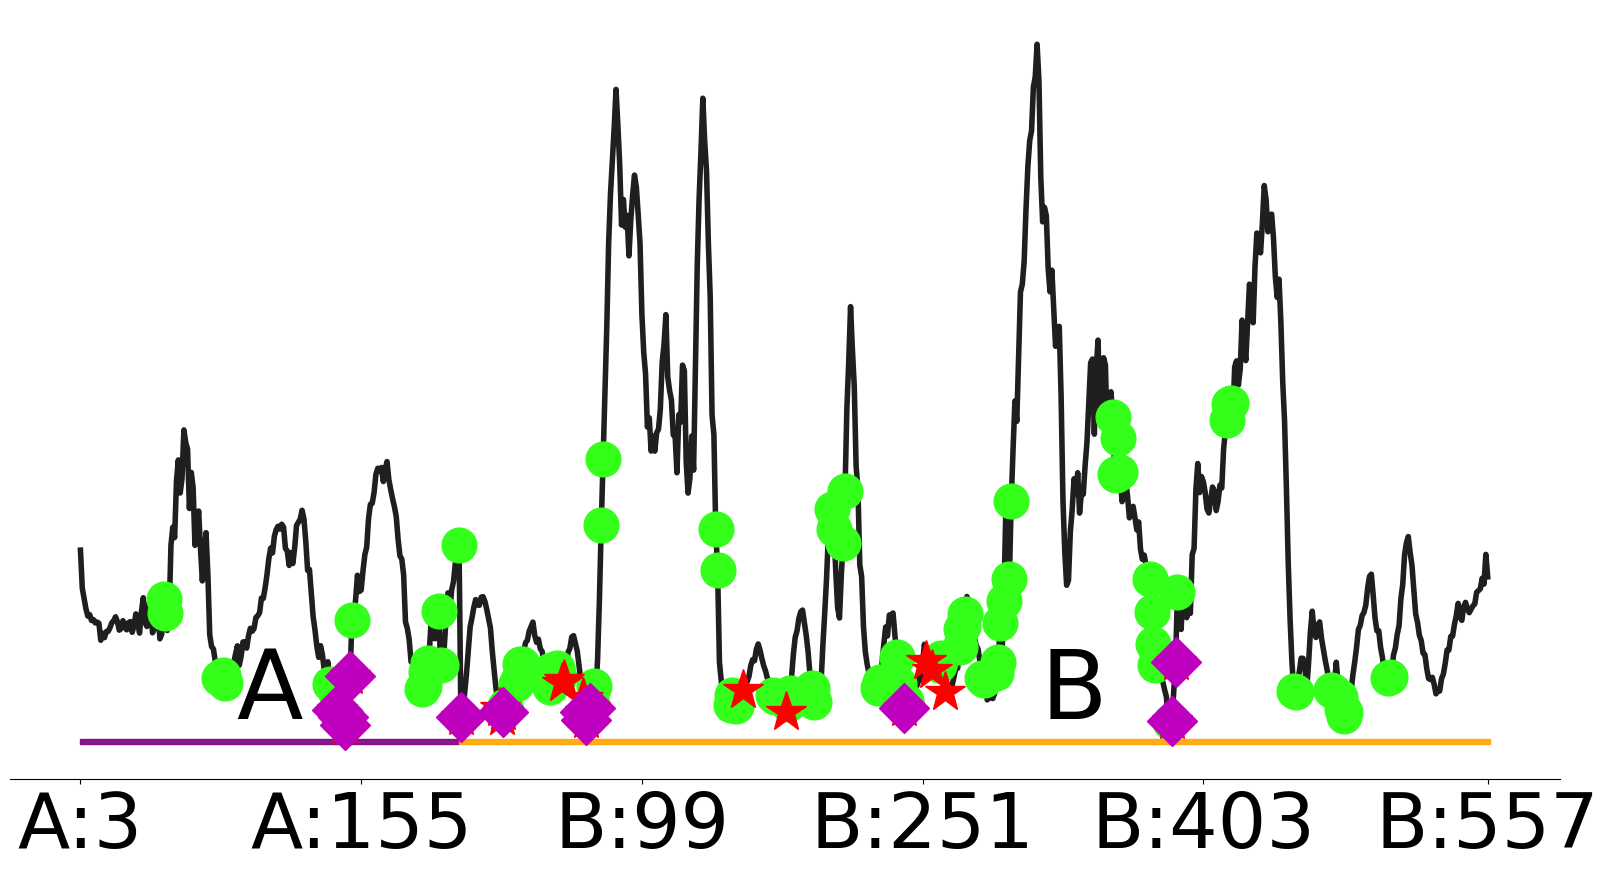

In [204]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
plt.sca(ax)  # Set current axis to 'ax'
    
# Increase font sizes
plt.rc('xtick', labelsize=55)
plt.rc('ytick', labelsize=50)
plt.rcParams.update({'font.size': 70})

# calcMSF
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVecs[i, mode] ** 2 / AverageEigVals2[mode]
    MSF.append(currMSF)

plt.plot(MSF, color='black', linewidth=4, alpha=0.88)

HingeY = [MSF[item] for item in currHinge]
plt.plot(currHinge, HingeY, color=(0.2, 1, 0.1), marker='o', linestyle='', markersize=25)
print ('# of hinges', len(HingeY))

# plot binding sites
bindingY = [MSF[item] for item in binding]
plt.plot(binding, bindingY, 'r*', markersize=30)
print ('# of bindings sites', len(binding))

# plot overlaps
allHinge = currHinge
overlaps = [item for item in binding if item in allHinge]
overlapsY = [MSF[item] for item in overlaps]
plt.plot(overlaps, overlapsY, 'mD', markersize=25)

print ('# of hits are', len(overlaps))

# Hide y labels
plt.gca().yaxis.set_visible(False)

# Hide top, right, and left spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

y = MSF
# Determine the lower y-limit for bands and labels
lower_y_limit = min(y) * 0.01
upper_y_limit = min(y) * 0.3

# Add narrow bands below the plot
ax.add_patch(patches.Rectangle((0, lower_y_limit), SplitLabel, upper_y_limit - lower_y_limit, color='purple', alpha=0.9))
ax.add_patch(patches.Rectangle((SplitLabel, lower_y_limit), proteinLength - SplitLabel, upper_y_limit - lower_y_limit, color='orange',alpha=0.9))
# Add labels just above the bands
ax.text(SplitLabel / 2, upper_y_limit, 'A', color='black', ha='center', va='bottom')
ax.text((SplitLabel + proteinLength) * 10 / 18, upper_y_limit, 'B', color='black', ha='center', va='bottom')

# Set x-axis labels and title with Arial font
# plt.title('Penicillin Acylase')
plt.xticks([0, Segment, Segment*2, Segment*3, Segment*4, proteinLength - 1], Labels)

plt.savefig('./PA_MSF.png', dpi=500)

In [193]:
min(y)

0.0009121617169374921

In [205]:
AverageEigVals2

array([ 0.33603595,  0.50504837,  0.84392904,  1.03601244,  1.34284965,
        1.64816301,  1.89775685,  2.02028983,  2.48091948,  2.44348619,
        2.8940828 ,  5.4066016 ,  3.08826684,  3.56081712,  3.39869179,
        3.82853532,  3.59345932,  4.28268988,  4.02346003,  6.78222831,
        4.3492571 ,  4.76730635,  4.70944269, 15.67038078,  4.55075408,
        6.02064269,  7.88474951,  5.15419031,  8.26585361,  6.36826643,
        5.56810264,  5.47599216,  5.64421997,  6.20776323,  6.67319778,
        6.24574206,  9.51267908,  6.45344442,  6.4954969 ,  6.90742233,
        6.79625622,  6.65578085,  7.42716397, 22.70573761,  8.76355794,
        8.91637577, 10.46786271,  7.7466214 ,  7.27730338,  8.1132272 ,
        8.42096654,  8.71769137,  8.04773239, 11.1504254 ,  8.7403521 ,
        8.69885296,  9.23715708,  8.50698287,  8.80321266, 10.35169993,
        9.13314766,  8.97881251, 10.90392214,  9.95181033, 14.62502917,
        9.73641971, 15.16984923, 10.63436685, 10.37877096, 10.02

In [97]:
averageEigVals.shape

(695,)

In [99]:
# write MSFs
# averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVecs.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVecs[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
len(MSF)

763

In [106]:
values_array = np.array(sqrt(MSF))

# Get indices of the 5 smallest values
indices = np.argsort(values_array)

if not os.path.exists('./Data'):
    os.mkdir('./Data')

writeNumbers('./Data/RMSF_minimum_diverse.txt', indices)

In [149]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVecs[:, 0]
curr[:, 3] = averageEigVecs[:, 1]
curr[:, 5] = averageEigVecs[:, 2]

for each in binding:
    curr[each, 0] = each

In [150]:
modes = [0, 1, 2]
row, col = averageEigVecs.shape

for mode in modes:
    currHinge = getHinges_modes2(averageEigVecs, mode, bandWidth=15)
    currHinge = filterTwoEnds(currHinge, [[0, 762]], 35)
    
    if mode == 0:
        currHinge = [x for x in currHinge if x not in [190, 191, 192, 193]]

    elif mode == 2:
        currHinge = [x for x in currHinge if x not in [82,83,85,86,415,416,418,419]]
    
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [151]:
writeAllData('./Data/PA_Method2_diverse.txt', curr)

# method 3

In [114]:
averageEigVecs.shape

(763, 695)

In [175]:
ubi = parsePDB('4m11', subset='calpha') # 1udu
calphas = ubi.select('calpha and chain A B')
gnm = GNM('PDE')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])
Hinge2 = calcHinges(gnm[3])

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 4m11 downloaded (4m11.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 2208 atoms and 1 coordinate set(s) were parsed in 0.12s.
@> Secondary structures were assigned to 1364 residues.
@> Kirchhoff was built in 0.05s.
@> 1103 modes were calculated in 0.40s.


In [196]:
Hinges_2 = getHinges3(averageEigVects,currNumModes, [Hinge0, Hinge1, Hinge2, Hinge3], 20)
Hinges_3 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 20)

Hinges_4 = getHinges3(averageEigVects, currNumModes, [Hinge0, Hinge1, Hinge2, Hinge3], 15)
Hinges_5 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 15)

In [197]:
Hinges_2 = filterTwoEnds(Hinges_2, chainLength = [[0, 550], [551, 1104]])
Hinges_3 = filterTwoEnds(Hinges_3, chainLength = [[0, 550], [551, 1104]])
Hinges_4 = filterTwoEnds(Hinges_4, chainLength = [[0, 550], [551, 1104]])
Hinges_5 = filterTwoEnds(Hinges_5, chainLength = [[0, 550], [551, 1104]])

In [115]:
Hinges_2 = getHinges3(averageEigVecs, currNumModes, [[], [], [], []], 20)
Hinges_3 = getHinges3(averageEigVecs, 3, [[], [], []], 20)

Hinges_4 = getHinges3(averageEigVecs, currNumModes, [[], [], [], []], 15)
Hinges_5 = getHinges3(averageEigVecs, 3, [[], [], []], 15)

In [194]:
Hinges_2 = filterTwoEnds(Hinges_2, chainLength = [[0, 550], [551, 1103]])
Hinges_3 = filterTwoEnds(Hinges_3, chainLength = [[0, 550], [551, 1103]])
Hinges_4 = filterTwoEnds(Hinges_4, chainLength = [[0, 550], [551, 1103]])
Hinges_5 = filterTwoEnds(Hinges_5, chainLength = [[0, 550], [551, 1103]])

In [116]:
protein_length = 763

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 22
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 116 11 0.00010329728572011643
# of hinge sites for first 3 modes, overlap, hyper score 116 11 0.00010329728572011643
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 116 11 0.00010329728572011643
# of hinge sites for first 3 modes, overlap, hyper score 116 11 0.00010329728572011643


In [181]:
print (sort(Hinges_5))

[  15   16   17   20   21   22   74   75   76   77   79   80   83   84
   85  104  105  106  108  109  110  115  116  160  161  178  179  180
  181  183  184  185  188  189  190  313  314  317  318  319  320  321
  325  326  342  343  357  358  359  360  399  400  499  500  501  502
  505  506  507  510  511  512  516  517  567  568  569  572  573  574
  605  606  626  627  628  629  631  632  635  656  657  659  660  661
  662  667  668  712  713  730  731  732  733  735  736  737  740  741
  742  743  865  866  868  869  871  872  877  878  894  895  909  910
  911  912  913  951  952 1051 1052 1053 1054 1057 1058 1059 1062 1063
 1064 1069 1070]


## writeResults

In [182]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)

In [183]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [186]:
row, col = averageEigVects.shape

Hinges_calc = [Hinge0, Hinge1, Hinge2]
i = 0
for mode in modes:
    currHinge = getHinges_modes3(averageEigVects, mode, Hinges_calc[i], bandWidth=15)
    i += 1
    currHinge = filterTwoEnds(currHinge, chainLength = [[0, 550], [551, 1104]])
    currList = sort(list(set(list(currHinge))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [187]:
writeAllData('./Data/COX2_Method3.txt', curr)

# Write Modes

In [36]:
def writeModesAsBfactors(mode, eigenVects):
    residue = []
    new_b_factor = []
    chain = 'A'

    resiIndex = 4
    for item in eigenVects[:, mode]:
        resiIndex += 1
        residue.append(resiIndex)
        new_b_factor.append(item)

    with open('./Structure_demo/ALB_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
        for i in range(len(residue)):
            wf.write(chain + ', ' + str(residue[i]) + ', ' + str(new_b_factor[i]) + '\n')

In [37]:
writeModesAsBfactors(0, eigenVects)
writeModesAsBfactors(1, eigenVects)

# Plot graphs

In [78]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import numpy as np

def format_significant(value, pos):
    if abs(value) <= 0.01:
        return "0.00"
    else:
        order_of_magnitude = math.floor(math.log10(abs(value)))
        round_digits = -order_of_magnitude + 1
        formatted_number = round(value, round_digits)
        str_format = "{:." + str(round_digits) + "f}"
        return str_format.format(formatted_number)


In [167]:
def plotSingleGraph(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3, chain=False)

    # Hinges within band
    # method1
    # currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    # method2
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    
    currHinge = filterTwoEnds(currHinge, [[0, 762]], 35)
    
    if mode == 0:
        currHinge = [x for x in currHinge if x not in [190, 191, 192, 193]]

    elif mode == 2:
        currHinge = [x for x in currHinge if x not in [82,83,85,86,415,416,418,419]]
    
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', [x for x in (currHinge)], len(currHinge))
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    updateHinge = [item for item in Hinge if item not in currHinge]
    HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    print ('local loop motion', updateHinge)
    plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = updateHinge + currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    
    plt.tight_layout()
    plt.savefig('./PA_method2Merging_mode' + str(mode + 1) + '.png', dpi=500)

Hinge residue with wide bands [657, 146, 147, 276, 277, 278, 407, 408, 658, 413, 414, 677, 678, 684, 685, 442, 443, 187, 188, 205, 206, 476, 477, 478, 479, 488, 489] 27
local loop motion []
current bindings are [139, 142, 143, 146, 206, 227, 228, 229, 261, 262, 272, 273, 274, 276, 359, 382, 446, 458, 461, 468, 591, 593]
current hits are [146, 206, 276]
# of overlaps finding from current mode is 3


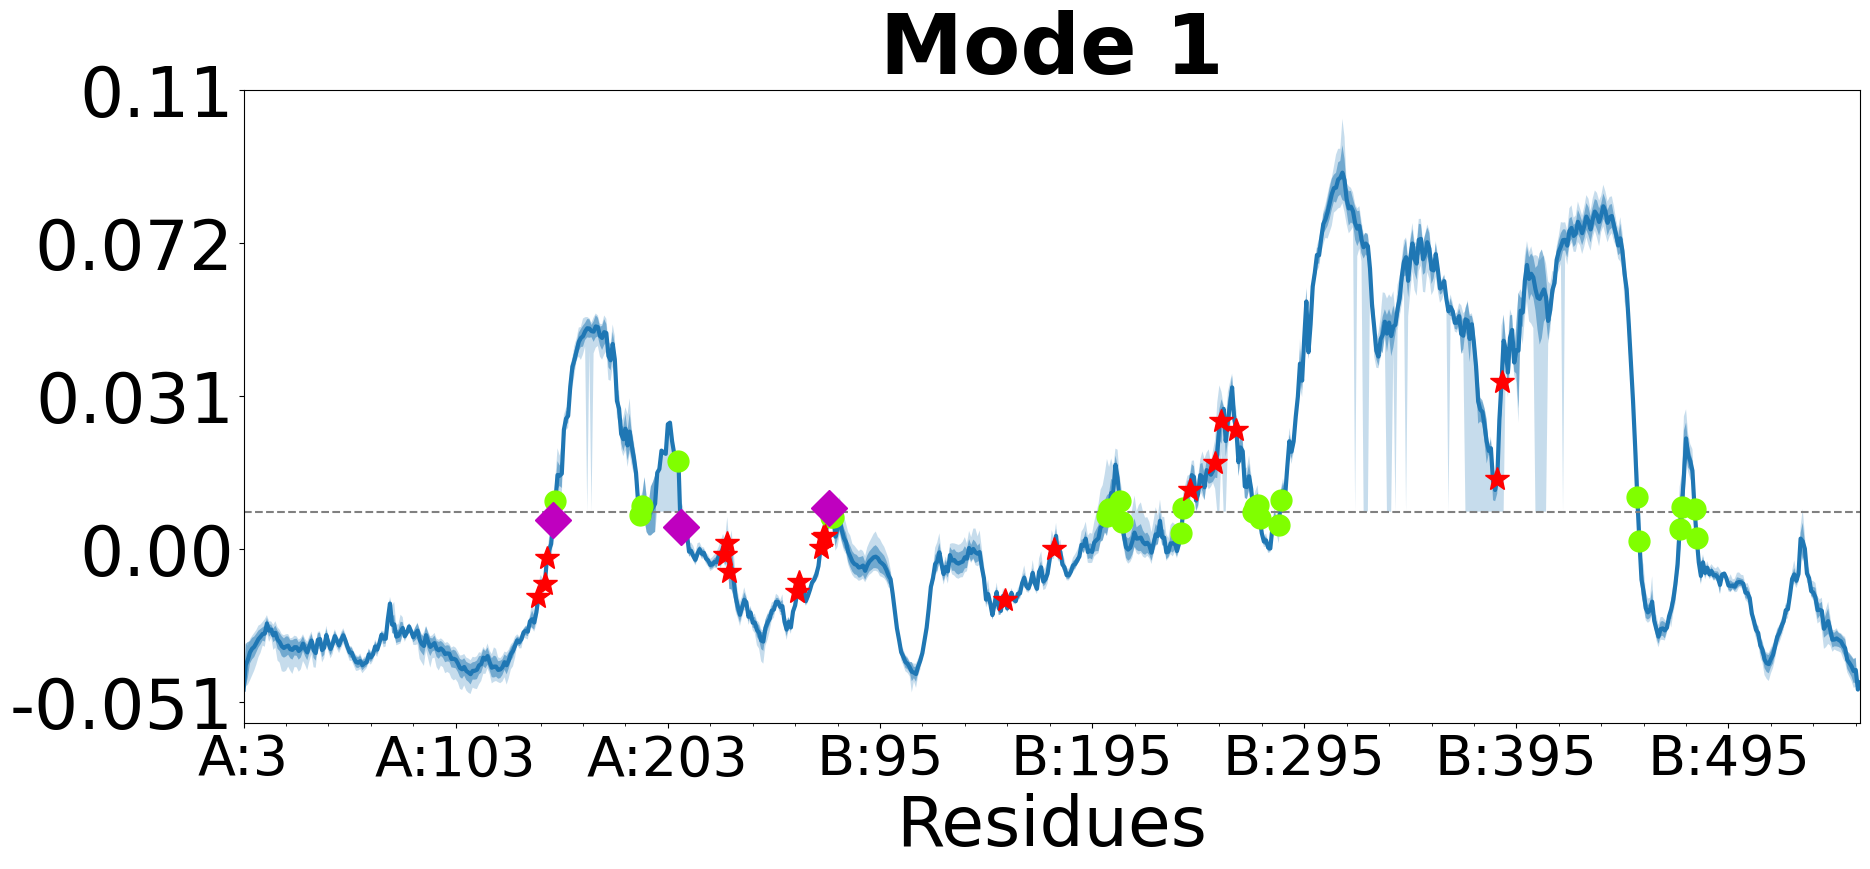

In [168]:
modes = 0 # Example modes
plotSingleGraph(modes, averageEigVecs, gnms, binding, [])

Hinge residue with wide bands [384, 135, 136, 138, 139, 396, 397, 273, 274, 45, 46, 559, 432, 433, 560, 185, 186, 446, 447, 194, 195, 579, 580, 75, 77, 78, 205, 206, 465, 466, 593, 594, 352, 353, 354, 355, 621, 622, 623, 375, 376, 383] 42
local loop motion []
current bindings are [139, 142, 143, 146, 206, 227, 228, 229, 261, 262, 272, 273, 274, 276, 359, 382, 446, 458, 461, 468, 591, 593]
current hits are [139, 206, 273, 274, 446, 593]
# of overlaps finding from current mode is 6


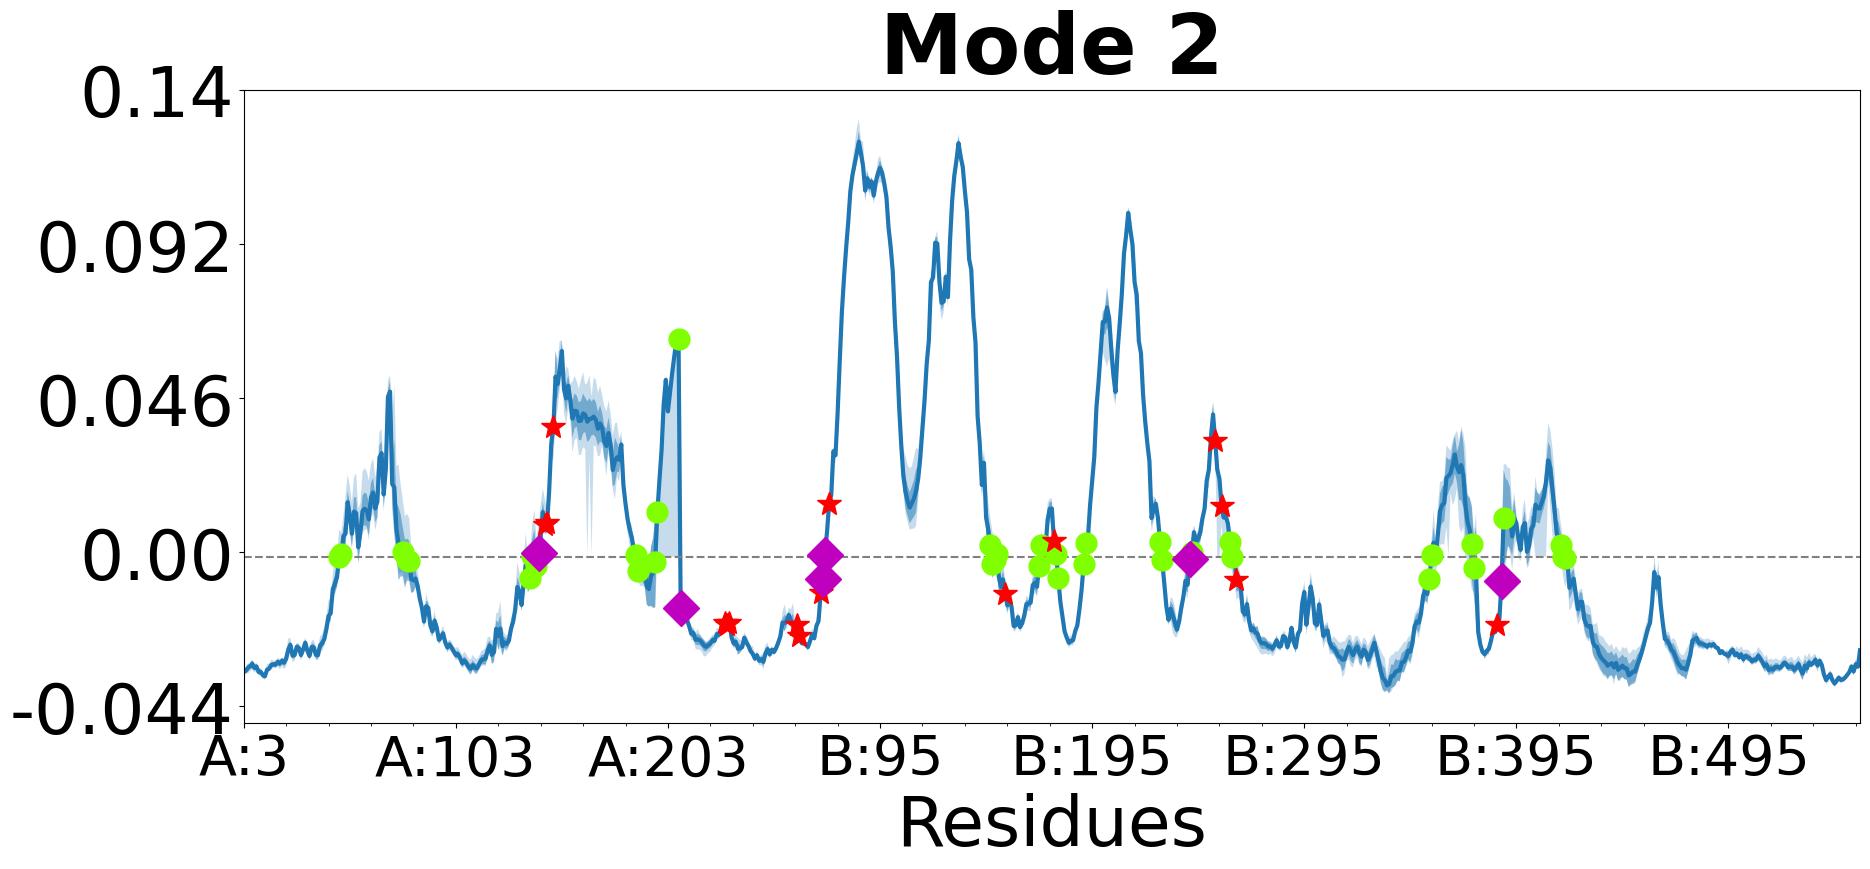

In [169]:
modes = 1 # Example modes
plotSingleGraph(modes, averageEigVecs, gnms, binding, [])

In [147]:
averageEigVecs[414:421, 2]

array([ 8.11921744e-03,  1.95937557e-05, -7.09916364e-03, -8.20334671e-03,
       -4.40846209e-03,  1.67743326e-03,  9.92813761e-03])

Hinge residue with wide bands [258, 259, 140, 141, 142, 143, 282, 283, 682, 683, 560, 561, 562, 563, 708, 581, 582, 709, 590, 591, 344, 345, 229, 230, 236, 237, 238, 239, 496, 497, 498, 621, 500, 622, 503, 504, 254, 255] 38
local loop motion []
current bindings are [139, 142, 143, 146, 206, 227, 228, 229, 261, 262, 272, 273, 274, 276, 359, 382, 446, 458, 461, 468, 591, 593]
current hits are [142, 143, 229, 591]
# of overlaps finding from current mode is 4


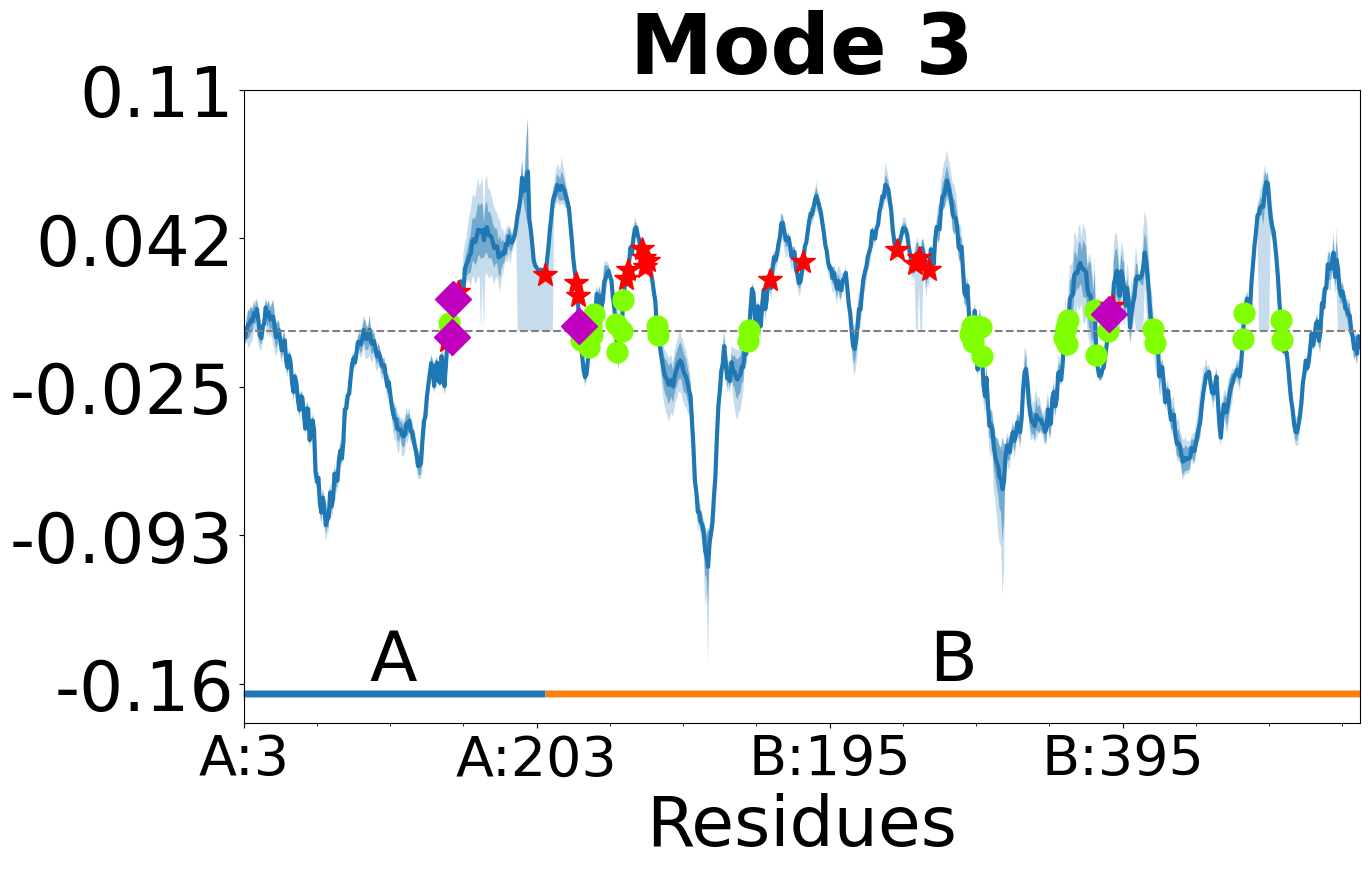

In [148]:
modes = 2 # Example modes
plotSingleGraph(modes, averageEigVecs, gnms, binding, [])

# store data

In [43]:
averageEigVecs.shape

(763, 695)

In [58]:
mode = 2

In [59]:
residue = []
new_b_factor = []

for item in averageEigVecs[:, mode]:
    new_b_factor.append(item)


In [60]:
resiIndex = [x for x in range(3, 209)]
chain = ['A' for x in range(3, 209)]


resiIndex += [x for x in range(1, 558)]
chain += ['B' for x in range(1, 558)]


In [61]:
with open('./structure_demo/PA_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
    for i in range(len(resiIndex)):
        # print (chain[i])
        wf.write(chain[i] + ', ' + str(resiIndex[i]) + ', ' + str(new_b_factor[i]) + '\n')

In [142]:
!pwd

/data/frank/Desktop/Hinges_Figures_all/COX2


In [47]:
len(resiIndex)

763

In [49]:
calphas.getSequence()

'SSSEIKIVRDEYGMPHIYANDTWHLFYGYGYVVAQDRLFQMEMARRSTQGTVAEVLGKDFVKFDKDIRRNYWPDAIRAQIAALSPEDMSILQGYADGMNAWIDKVNTNPETLLPKQFNTFGFTPKRWEPFDVAMIFVGTMANRFSDSTSEIDNLALLTALKDKYGVSQGMAVFNQLKWLVNPSAPTTIAVQESNYPLKFNQQNSQTSNMWVIGKSKAQDAKAIMVNGPQFGWYAPAYTYGIGLHGAGYDVTGNTPFAYPGLVFGHNGVISWGSTAGFGDDVDIFAERLSAEKPGYYLHNGKWVKMLSREETITVKNGQAETFTVWRTVHGNILQTDQTTQTAYAKSRAWDGKELASLLAWTHQMKAKNWQEWTQQAAKQALTINWYYADVNGNIGYVHTGAYPDRQSGHDPRLPVPGTGKWDWKGLLPFEMNPKVYNPQSGYIANWANSPQKDYPASDLFAFLWGGADRVTEIDRLLEQKPRLTADQAWDVIRQTSRQDLNLRLFLPTLQAATSGLTQSDPRRQLVETLTRWDGINLLNDDGKTWQQPGSAILNVWLTSMLKRTVVAAVPMPFDKWYSASGYETTQDGPTGSLNISVGAKILYEAVQGDKSPIPQAVDLFAGKPQQEVVLAALEDTWETLSKRYGNNVSNWKTPAMALTFRANNFFGVPQAAAEETRHQAEYQNRGTENDMIVFSPTTSDRPVLAWDVVAPGQSGFIAPDGTVDKHYEDQLKMYENFGRKSLWLTKQDVEAHKESQEVLHVQR'